In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

# https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.date_range.html
# https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#timeseries-offset-aliases
# https://datatofish.com/random-integers-pandas-dataframe/
# https://pandas.pydata.org/docs/reference/api/pandas.Series.dt.dayofweek.html
# https://stackoverflow.com/questions/29096381/num-day-to-name-day-with-pandas

# https://towardsdatascience.com/how-to-group-data-by-different-time-intervals-using-python-pandas-eb7134f9b9b0
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.resample.html
# https://www.youtube.com/watch?v=UFuo7EHI8zc
#   ~23:50

# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Grouper.html

In [2]:
## 001 ##
# functions to create n months's worth of dummy time data of parking sensor bays

'''
endTime = "2021-09-02 15:01:23"
fq = "15min"  # or 'H' for hourly, 'D' for daily
per = 3*30*24*4  # ~3mth x 30 days x 24 hours x 4(15min)
recordsPerTimeStamp = 3  # number of records per timestamp (akin to number of selected parking sensors)
bayFr, bayTo = 998, 1028  # bay_id range to be randomly draw from
'''

def simParkSensorData1(endTime, fq, per, recordsPerTimeStamp, bayFr, bayTo):
    w = pd.Series(pd.date_range(end=endTime, periods=per, freq=fq))
    lst = []
    for i in range(recordsPerTimeStamp):
        a = pd.Series(np.random.randint(bayFr,bayTo,size=len(w)))
        aw = pd.concat([a,w], axis='columns')
        lst.append(aw)

    _df = pd.concat(lst, axis='index')
    _df.columns = ['bay_id','db_read_time']
    _df = _df.drop_duplicates().reset_index(drop=True)

    _df['status'] = np.random.randint(0,2,size=len(_df))
    _df['status'] = _df['status'].replace({0:"Unoccupied", 1:"Present"})
    _df = _df.sort_values(by=['db_read_time','bay_id'])
    
    print(f'''Generated {_df["db_read_time"].count()} records in \
        {_df["db_read_time"].nunique()} time periods over \
        {_df["db_read_time"].dt.date.nunique()} days \
        (frequency of time period = {fq}).''')
          #.format(_df["db_read_time"].count(),_df["db_read_time"].nunique(),_df["db_read_time"].dt.date.nunique()))
     
    # _df.to_csv("datasets/simulatedTimeData_IncompleteParkingSensors.csv", index=False)
    return _df

def simParkSensorData2(endTime, fq, per, bayFr, bayTo):
    w = pd.Series(pd.date_range(end=endTime, periods=per, freq=fq))
    lst = []
    for i in range(bayTo+1-bayFr):
        a = pd.Series(np.repeat((bayFr+i),len(w)))
        aw = pd.concat([a,w], axis='columns')
        lst.append(aw)

    _df = pd.concat(lst, axis='index')
    _df.columns = ['bay_id','db_read_time']
#     _df = _df.drop_duplicates()

    _df['status'] = np.random.randint(0,2,size=len(_df))
    _df['status'] = _df['status'].replace({0:"Unoccupied", 1:"Present"})
    _df = _df.sort_values(by=['db_read_time','bay_id']).reset_index(drop=True)
    
    print(f'''Generated {_df["db_read_time"].count()} records in \
        {_df["db_read_time"].nunique()} time periods over \
        {_df["db_read_time"].dt.date.nunique()} days \
        (frequency of time period = {fq}).''')
          #.format(_df["db_read_time"].count(),_df["db_read_time"].nunique(),_df["db_read_time"].dt.date.nunique()))
     
    # _df.to_csv("datasets/simulatedTimeData_CompleteParkingSensors.csv", index=False)
    return _df

In [21]:
## 001a ##
# test function here

df = simParkSensorData2("2021-09-02 15:01:23", "15min", 6*30*24*4, 999, 1002)
df.head()

Generated 69120 records in         17280 time periods over         181 days         (frequency of time period = 15min).


,bay_id,db_read_time,status
0,999,2021-03-06 15:16:23,Present
1,1000,2021-03-06 15:16:23,Present
2,1001,2021-03-06 15:16:23,Unoccupied
3,1002,2021-03-06 15:16:23,Present
4,999,2021-03-06 15:31:23,Unoccupied


In [46]:
df.head(20)

,bay_id,db_read_time,status
0,999,2021-03-06 15:16:23,Present
1,1000,2021-03-06 15:16:23,Present
2,1001,2021-03-06 15:16:23,Unoccupied
3,1002,2021-03-06 15:16:23,Present
4,999,2021-03-06 15:31:23,Unoccupied
5,1000,2021-03-06 15:31:23,Unoccupied
6,1001,2021-03-06 15:31:23,Unoccupied
7,1002,2021-03-06 15:31:23,Present
8,999,2021-03-06 15:46:23,Unoccupied
9,1000,2021-03-06 15:46:23,Unoccupied


In [22]:
## 002 ##
# input is list of bay ids and ETL dataframe
# output is time records from ETL dataframe that matches match the input list if bay ids

def filter_bayRec_from_ETL(bay_ids_lst, etl_df):
    return etl_df[etl_df['bay_id'].isin(bay_ids_lst)]

In [23]:
## 002a ##
# test function here

df_filtered = filter_bayRec_from_ETL([999,1000],df)
df_filtered.head()

,bay_id,db_read_time,status
0,999,2021-03-06 15:16:23,Present
1,1000,2021-03-06 15:16:23,Present
4,999,2021-03-06 15:31:23,Unoccupied
5,1000,2021-03-06 15:31:23,Unoccupied
8,999,2021-03-06 15:46:23,Unoccupied


In [13]:
## 003 ##
# input is dataframe, and time parameters that has defaults
# outputs aggregated data (average status counts in a bin)
# apart from average, can change aggregated data to give median/min/max 

def last_hrs(_df, no_hrs=24, bin_size_mins='15min', endDatetime=datetime.now()):
    dfpv = pd.pivot_table(_df, index="db_read_time", columns="status", aggfunc='count')
    dfpv = dfpv.fillna(0)
    dfpv.columns = ["P","U"]

    startDatetime = endDatetime - timedelta(hours=no_hrs)
    dfpv = dfpv.loc[startDatetime : endDatetime]  # filter between specified times
    
    aa = dfpv['P'].resample(bin_size_mins).mean()  # average number of occuppied sensors out of these filtered set of sensors
    bb = dfpv['U'].resample(bin_size_mins).mean()
    
    df = pd.concat([aa,bb], axis='columns')
    df.columns = ['Present','Unoccupied']
    df.index.name = 'time interval'
    return df

In [24]:
## 003a ##
# test function here

df_lasthours = last_hrs(df_filtered,24,'15min')
df_lasthours

,Present,Unoccupied
time interval,,
2021-08-11 13:45:00,1.0,1.0
2021-08-11 14:00:00,0.0,2.0
2021-08-11 14:15:00,0.0,2.0
2021-08-11 14:30:00,1.0,1.0
2021-08-11 14:45:00,1.0,1.0
...,...,...
2021-08-12 12:30:00,1.0,1.0
2021-08-12 12:45:00,1.0,1.0
2021-08-12 13:00:00,1.0,1.0


In [16]:
## 004 ##
# input is dataframe, and time parameters that has defaults
# outputs aggregated data (average status counts in a bin)
# apart from average, can change aggregated data to give median/min/max 

def last_mdays(_df, no_days=30, bin_size_mins='60min', endDatetime=datetime.now()):
    dfpv = pd.pivot_table(_df, index="db_read_time", columns="status", aggfunc='count')
    dfpv = dfpv.fillna(0)
    dfpv.columns = ["P","U"]

    startDatetime = endDatetime - timedelta(days=no_days)
    dfpv = dfpv.loc[startDatetime : endDatetime]  # filter between specified times
    
    aa = dfpv['P'].resample(bin_size_mins).median()  # average number of occuppied sensors out of these filtered set of sensors
    bb = dfpv['U'].resample(bin_size_mins).median()
    df = pd.concat([aa,bb], axis='columns')
    df.columns = ['Present','Unoccupied']
    df.index.name = 'time interval'
    return df

In [25]:
## 004a ##
# test function here

df_lastdays = last_mdays(df,5,'60min')
df_lastdays

,Present,Unoccupied
time interval,,
2021-08-07 13:00:00,3.0,1.0
2021-08-07 14:00:00,2.5,1.5
2021-08-07 15:00:00,1.5,2.5
2021-08-07 16:00:00,2.0,2.0
2021-08-07 17:00:00,1.0,3.0
...,...,...
2021-08-12 09:00:00,2.5,1.5
2021-08-12 10:00:00,2.5,1.5
2021-08-12 11:00:00,2.0,2.0


In [18]:
## 005 ##
# input is dataframe, and time parameters that has defaults
# outputs aggregated data (average status counts in a bin)
# apart from average, can change aggregated data to give median/min/max 

def last_periods(_df, no_days=60, bin_period='W-MON', endDatetime=datetime.now()):
    dfpv = pd.pivot_table(_df, index="db_read_time", columns="status", aggfunc='count')
    dfpv = dfpv.fillna(0)
    dfpv.columns = ["P","U"]

    startDatetime = endDatetime - timedelta(days=no_days)
    dfpv = dfpv.loc[startDatetime : endDatetime]  # filter between specified times
    
    aa = dfpv['P'].resample(bin_period).mean()  # average number of occuppied sensors out of these filtered set of sensors
    bb = dfpv['U'].resample(bin_period).mean()
    df = pd.concat([aa,bb], axis='columns')
    df.columns = ['Present','Unoccupied']
    df.index.name = 'time interval'
    return df

In [44]:
## 005a ##
# test function here

df_lastweeks = last_periods(df,60,'D')
df_lastweeks

,Present,Unoccupied
time interval,,
2021-06-13,2.097561,1.902439
2021-06-14,2.083333,1.916667
2021-06-15,1.927083,2.072917
2021-06-16,1.989583,2.010417
2021-06-17,2.083333,1.916667
...,...,...
2021-08-08,1.875000,2.125000
2021-08-09,1.958333,2.041667
2021-08-10,2.083333,1.916667


In [27]:
## 005b ##
# test function here

df_lastmonths = last_periods(df,60,'MS')
df_lastmonths

,Present,Unoccupied
time interval,,
2021-06-01,1.989241,2.010759
2021-07-01,2.015457,1.984543
2021-08-01,1.981098,2.018902


<AxesSubplot:xlabel='time interval'>

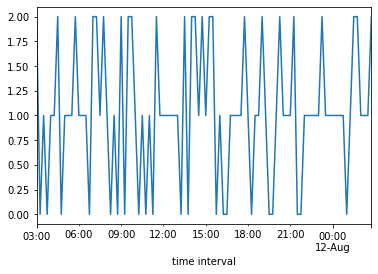

In [494]:
df_lasthours['Present'].plot()

In [37]:
## 006
# can probably filter on particular weekdays (e.g. Mondays over last 12 weeks ?)

# input is dataframe with datetime index, and a list of days of week we want filtered

def dayOfWeek_timeData(_df, dow):
    return _df[_df.index.dayofweek.isin(dow)]

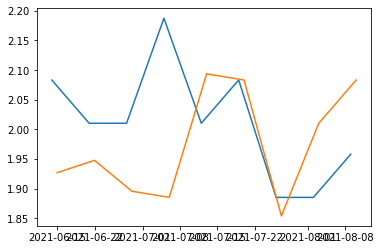

In [43]:
## 006a
# test function

mon = dayOfWeek_timeData(df_lastweeks,[0])
tue = dayOfWeek_timeData(df_lastweeks,[1])
wed = dayOfWeek_timeData(df_lastweeks,[3])

plt.plot(mon['Present'])
plt.plot(tue['Present'])


In [28]:
dow = df_lastdays.index.dayofweek  # 0=Monday .. 6=Sunday
dow

In [48]:
mon.head()

,Present,Unoccupied
time interval,,
2021-06-14,2.083333,1.916667
2021-06-21,2.010417,1.989583
2021-06-28,2.010417,1.989583
2021-07-05,2.187500,1.812500
2021-07-12,2.010417,1.989583


In [49]:
tue.head()

,Present,Unoccupied
time interval,,
2021-06-15,1.927083,2.072917
2021-06-22,1.947917,2.052083
2021-06-29,1.895833,2.104167
2021-07-06,1.885417,2.114583
2021-07-13,2.093750,1.906250
